# Comparing ERA5 AR anomalies with Nino34 Index

This code correlates and regresses the monthly ERA5 AR anomalies with the Nino3.4 index

* Input: `/glade/work/mkorendy/clim680/nino34.txt`
* Input: `/glade/work/mkorendy/metisregimes/era5.AR.10%.PNA.NDJFM.anoms.nc`

1. Takes the monthly average of ERA5 atmospheric river anomaly count
2. Correlate monthly AR anomaly and Nino3.4 index

* Output: `era5.AR.10%.PNA.NDJFM.anoms.Nino34_corr.png`
* Output: `era5.AR.10%.PNA.NDJFM.anoms.Nino34_reg.png`

## Imports

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from scipy.stats import pearsonr
from scipy.stats import linregress

## Files

In [2]:
# Path
path = '/glade/work/mkorendy/'

# Nino3.4 input
f_nino = path + 'clim680/nino34.txt'

# ERA5 AR anomaly input
f_ar = path + 'metisregimes/era5.AR.10%.PNA.NDJFM.anoms.nc'

#Output:
f_corr = 'era5.AR.10%.PNA.NDJFM.anoms.Nino34_corr.png'
f_reg = 'era5.AR.10%.PNA.NDJFM.anoms.Nino34_reg.png'

## Read in data

### Nino3.4 data

In [3]:
df_nino = pd.read_table(f_nino,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df_nino.drop(df_nino.tail(3).index,inplace=True)

### Convert Nino34 data from dataframe to dataset

In [4]:
# Get time stamps for dataset
start_date=str(df_nino.index[0])+'-'+str(df_nino.columns[0])+'-01'
end_date=str(df_nino.index[-1])+'-'+str(df_nino.columns[-1])+'-01'

dates=pd.date_range(start=start_date,end=end_date,freq='MS')

# Turn dataframe into array
nino_index=df_nino.T.unstack().values

# Turn array into dataset
ds_nino=xr.DataArray(nino_index,
                      coords={'time':dates},
                              dims=['time']).to_dataset(name='nino34')

### ERA5 AR anomaly data

In [5]:
ds_ar = xr.open_dataset(f_ar)

## Monthly means of ERA5 AR anomalies, and NDJFM 1986-2016 Nino34 values

In [6]:
# List of monthly means per year over all years
ls_ar = []

# List of Nino34 indices for 1986-2016 NDJFM
ls_nino = []

# For each year, calculate monthly means
# And append to the list of monthly means per year
for yr in np.arange(1986,2016):
    ls_ar.append(ds_ar.sel(time=slice(str(yr) + '-11', str(yr+1) + '-04')).groupby('time.month').mean())
    ls_nino.append(ds_nino.sel(time=slice(str(yr) + '-11', str(yr+1) + '-03')))

# Concatenate the datasets together
ds_ar_means = xr.concat(ls_ar, dim='year')
ds_nino_index = xr.concat(ls_nino, dim='time')

# Reshape AR mean dataset by collapsing years and months together
ds_ar_means = xr.DataArray(ds_ar_means.river.values.reshape(len(ds_ar_means.year)*len(ds_ar_means.month),22,53),
                coords={'time':ds_nino_index.time, 'lat':ds_ar_means.lat, 'lon':ds_ar_means.lon},
                dims=['time','lat','lon']).to_dataset(name = 'river')

## Correlate ERA5 monthly mean anomalies with Nino3.4 index

In [7]:
# Convert Nino3.4 to float
ds_nino_index = ds_nino_index.astype(float)

In [8]:
r_map = xr.corr(ds_nino_index['nino34'],ds_ar_means['river'],dim='time')

### Significance of correlation

In [9]:
nx=len(ds_ar_means['lon'])
ny=len(ds_ar_means['lat'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))

for i in range(nx):
    for j in range(ny):
        r,p=pearsonr(ds_nino_index['nino34'],ds_ar_means['river'][:,j,i])
        r_array[j,i]=r
        p_array[j,i]=p

/glade/work/mkorendy/my_npl_clone/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
mask_sig=np.where(p_array<0.05,r_array,np.nan)

/glade/work/mkorendy/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


### Plot Correlation Map with significance

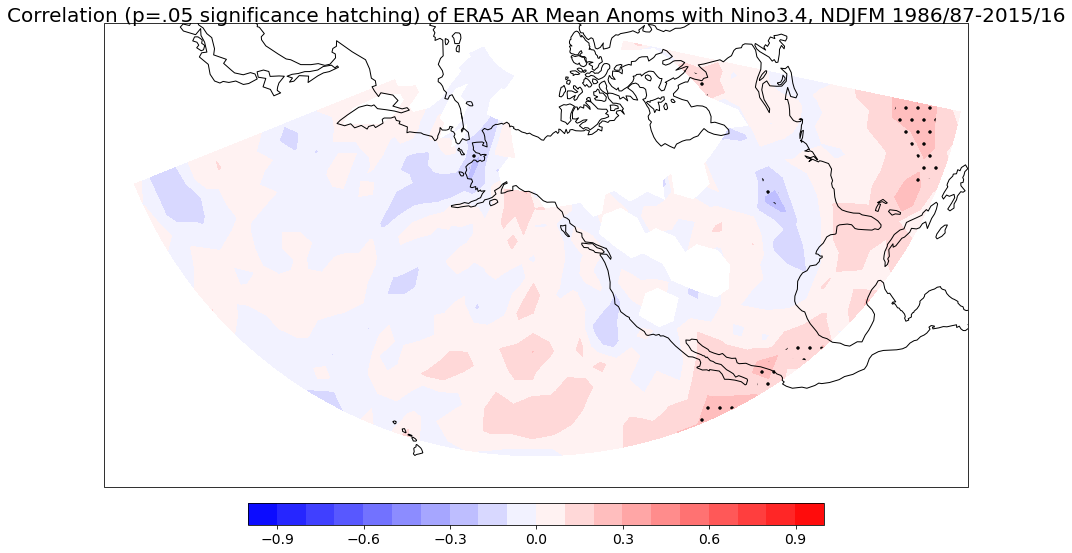

In [11]:
cm = 220
minlon = -70 + cm
maxlon = 80 + cm

data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)
levs = np.arange(-1,1.1,0.1)

# Set the axes using the specified map projection
fig,axs=plt.subplots(1,1,subplot_kw={'projection':proj},figsize=(20,15))

axs.set_extent((minlon+15,maxlon-25,10,90))
cs = axs.contourf(ds_ar_means['lon'], ds_ar_means['lat'], r_map, levs, transform=ccrs.PlateCarree(),cmap='bwr')
cs2 = axs.contourf(ds_ar_means['lon'],ds_ar_means.lat, mask_sig, [0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

axs.coastlines()
cbar_ax = fig.add_axes([0.3, 0.5, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
fig.subplots_adjust(bottom=0, top=1.5, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
plt.suptitle('Correlation (p=.05 significance hatching) of ERA5 AR Mean Anoms with Nino3.4, NDJFM 1986/87-2015/16' ,fontsize=20)
plt.savefig(f_corr)

## Regress ERA5 AR anoms onto Nino3.4

In [12]:
nx=len(ds_ar_means['lon'])
ny=len(ds_ar_means['lat'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))
m_array=np.zeros((ny,nx))

x=ds_nino_index['nino34']

for i in range(nx):
    for j in range(ny):
        

        y=ds_ar_means['river'][:,j,i]
        
        m,b,r,p,e = linregress(x,y)
        
        m_array[j,i]=m
        r_array[j,i]=r
        p_array[j,i]=p

### Significance mask

In [13]:
mask_sig=np.where(p_array<0.05,m_array,np.nan)

In [15]:
m_array

array([[ 0.00000000e+00, -1.07301420e-04, -1.07301420e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.07301420e-04, -1.07301420e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.63324964e-07,  9.63324964e-07,  9.63324964e-07],
       ...,
       [-1.92364578e-03, -2.28470338e-03, -2.79346726e-03, ...,
         1.71743700e-03,  2.96879792e-03,  4.06496642e-03],
       [-2.13525326e-03, -1.55568397e-03, -1.78574518e-03, ...,
         2.41771237e-03,  2.24176126e-03,  2.12022670e-03],
       [ 8.59313881e-04, -3.51092715e-05,  4.16784469e-04, ...,
         6.51780981e-04,  1.23681326e-03,  4.67663490e-04]])

### Plot the regression and the significance

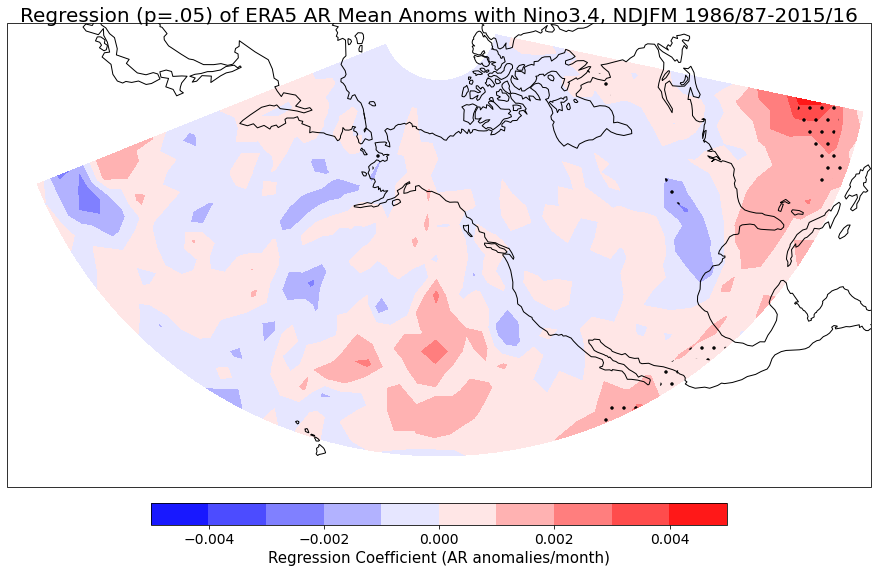

In [20]:
cm = 220
minlon = -70 + cm
maxlon = 80 + cm

data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)
levs = np.arange(-.005,.006,0.001)

# Set the axes using the specified map projection
fig,axs=plt.subplots(1,1,subplot_kw={'projection':proj},figsize=(20,15))

axs.set_extent((minlon+15,maxlon-25,10,90))
cs = axs.contourf(ds_ar_means['lon'], ds_ar_means['lat'], m_array, levs, transform=ccrs.PlateCarree(),cmap='bwr')
cs2 = axs.contourf(ds_ar_means['lon'],ds_ar_means.lat, mask_sig, [0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

axs.coastlines()

cbar_ax = fig.add_axes([0.3, 0.5, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.set_label(label='Regression Coefficient (AR anomalies/month)',size=15)
cbar.ax.tick_params(labelsize=14)

fig.subplots_adjust(bottom=0, top=1.5, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
plt.suptitle('Regression (p=.05) of ERA5 AR Mean Anoms with Nino3.4, NDJFM 1986/87-2015/16' ,fontsize=20)
plt.savefig(f_reg)